# OSKELM

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from time import perf_counter
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from TfELM.Layers.OSELMLayer import OSELMLayer
from TfELM.Models.OSELMModel import OSELMModel
from sklearn.model_selection import RepeatedKFold, cross_val_score

from alzheption.utils import custom_cross_val_score
from alzheption.clahe import Clahe
from alzheption.extractor import AlzheptionExtractor

2025-03-17 23:07:45.811294: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-17 23:07:45.826741: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742227665.846529  107235 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742227665.851143  107235 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-17 23:07:45.866219: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
def custom_grayscale_threshold(img):
    img[img < 0.5] = 0                                   # Apply thresholding
    return img

In [3]:
name = "Original"

list_aug = ["hflip", "rotate", "blur", "shear"]
name = f'{name}_{"".join([aug.title() for aug in list_aug])}'
name_dataset = f'dataset_jpg_brightness_balance_augmentation_{"_".join([aug for aug in list_aug])}'

alex_1 = AlzheptionExtractor.load_extractor(
    f"result/AlzheptionExtractor_{name}.pkl", 
    path_dataset_new=f'../../asset/{name_dataset}/',
)

alex_1.train_features.shape, alex_1.test_features.shape

((2280, 2048), (570, 2048))

In [4]:
alex_1.dataset

Dataset ImageFolder
    Number of datapoints: 2850
    Root location: ../../asset/dataset_jpg_brightness_balance_augmentation_hflip_rotate_blur_shear/

In [5]:
alex_1.dataset[0]

(<PIL.Image.Image image mode=RGB size=256x256>, 0)

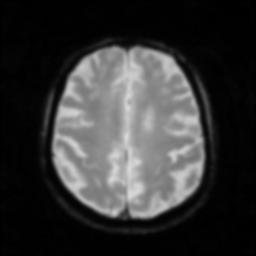

In [6]:
alex_1.dataset[0][0]

In [7]:
alex_1.view_train_label_distribution()

,label,count
0,0,375
1,1,381
2,2,375
3,3,384
4,4,377
5,5,388


In [8]:
alex_1.view_test_label_distribution()

,label,count
0,0,100
1,1,94
2,2,100
3,3,91
4,4,98
5,5,87


In [ ]:
# Cross Validation Param:
n_splits = 5
n_repeats = 5

# Hyperparameter:
list_batch_size = [32, 64, 128, 256, 512, 1024, 2048]
# list_batch_size = [4096]
list_num_neurons = [50, 100, 200, 400, 800, 1600]
# list_num_neurons = [3200]
list_activation = ["sigmoid", "tanh", "relu", "leaky_relu", "silu", "mish"]
# list_activation = ["relu"]

hyperparameter = [
    {
        "batch_size": batch_size,
        "num_neurons": num_neurons,
        "activation": activation,
    } for batch_size in list_batch_size for num_neurons in list_num_neurons for activation in list_activation
]

In [ ]:
data = []
for param in tqdm(hyperparameter, desc="CV"):
    tic = perf_counter()
    
    layer = OSELMLayer(param.get("num_neurons"), param.get("activation"))
    model = OSELMModel(layer, prefetch_size=param.get("num_neurons"), batch_size=param.get("batch_size"), verbose=0)

    cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats)
    scores = cross_val_score(model, alex_1.train_features, alex_1.train_labels, cv=cv, scoring='accuracy', error_score='raise')
    final_score = np.mean(scores)
    
    data.append({
        "batch_size": param.get("batch_size"), 
        "num_neurons": param.get("num_neurons"),
        "activation": param.get("activation"),
        "scores": scores.tolist(),
        "final_score": final_score,
        "elapsed":perf_counter() - tic,
    })

In [19]:
param

{'batch_size': 32, 'num_neurons': 3200, 'activation': 'relu'}

In [16]:
df = pd.DataFrame(data)

df.drop(columns=["scores"]).sort_values(by=["final_score"]).tail(30)

,batch_size,num_neurons,activation,final_score,elapsed
176,512,1600,relu,0.411053,10.277048
14,32,200,relu,0.411667,3.176972
53,64,200,mish,0.412281,2.389970
88,128,200,silu,0.414211,1.986280
52,64,200,silu,0.414737,2.517800
104,128,1600,relu,0.417719,11.158354
130,256,400,silu,0.421053,2.222884
17,32,200,mish,0.421316,3.337991
128,256,400,relu,0.428070,2.139801
94,128,400,silu,0.471667,2.928300


In [13]:
df.to_parquet(f"result/TrainOSELM_{name}.parquet", index=False)

In [14]:
raise

RuntimeError: No active exception to reraise

In [ ]:
pd.read_parquet("result/TrainOSELM_Original.parquet").drop(columns=["scores"]).sort_values(by=["final_score"]).tail()

,batch_size,num_neurons,activation,final_score
248,1024,3200,relu,0.575853
208,512,3200,silu,0.575877
124,128,3200,silu,0.577635
250,1024,3200,silu,0.580253
40,32,3200,silu,0.589025


In [ ]:
# Train KELM on the extracted training features
model.fit(alex_1.train_features, alex_1.train_labels)

In [ ]:
alex_1.train_features.shape, alex_1.test_features.shape

((1368, 2048), (342, 2048))

In [ ]:
# Evaluate the KELM model on the test set
predictions = model.predict(alex_1.train_features)
accuracy = accuracy_score(predictions, alex_1.train_labels)
print(f"Train Accuracy: {accuracy:.4f}")

# Evaluate the KELM model on the test set
predictions = model.predict(alex_1.test_features)
accuracy = accuracy_score(predictions, alex_1.test_labels)
print(f"Test Accuracy: {accuracy:.4f}")

Train Accuracy: 1.0000
Test Accuracy: 0.8626
